# MuJoCo basics

We begin by defining and loading a simple model:

In [1]:
import mujoco
import mediapy as media
import matplotlib.pyplot as plt

import time
import itertools
import numpy as np

## Friction

Let's see the effect of changing friction values

In [2]:
MJCF = """
<mujoco>
  <asset>
    <texture name="grid" type="2d" builtin="checker" rgb1=".1 .2 .3"
     rgb2=".2 .3 .4" width="300" height="300" mark="none"/>
    <material name="grid" texture="grid" texrepeat="6 6"
     texuniform="true" reflectance=".2"/>
     <material name="wall" rgba='.5 .5 .5 1'/>
  </asset>

  <default>
    <geom type="box" size=".05 .05 .05" />
    <joint type="free"/>
  </default>

  <worldbody>
    <light name="light" pos="-.2 0 1"/>
    <geom name="ground" type="plane" size=".5 .5 10" material="grid"
     zaxis="-.3 0 1" friction=".1"/> 
    <camera name="y" pos="-.1 -.6 .3" xyaxes="1 0 0 0 1 2"/>
    <body pos="0 0 .1">
      <joint/>
      <geom/>
    </body>
    <body pos="0 .2 .1">
      <joint/>
      <geom friction=".33"/>
    </body>
  </worldbody>

</mujoco>
"""
n_frames = 60
height = 300
width = 300
frames = []

# load
model = mujoco.MjModel.from_xml_string(MJCF)
data = mujoco.MjData(model)
renderer = mujoco.Renderer(model, height, width)

# simulate and render
mujoco.mj_resetData(model, data)
for i in range(n_frames):
  while data.time < i/30.0:
    mujoco.mj_step(model, data)
  renderer.update_scene(data, "y")
  frame = renderer.render()
  frames.append(frame)
media.show_video(frames, fps=30)

# Tendons, actuators and sensors

In [2]:
MJCF = """
<mujoco>
  <asset>
    <texture name="grid" type="2d" builtin="checker" rgb1=".1 .2 .3"
     rgb2=".2 .3 .4" width="300" height="300" mark="none"/>
    <material name="grid" texture="grid" texrepeat="1 1"
     texuniform="true" reflectance=".2"/>
  </asset>

  <worldbody>
    <light name="light" pos="0 0 1"/>
    <geom name="floor" type="plane" pos="0 0 -.5" size="2 2 .1" material="grid"/>
    <site name="anchor" pos="0 0 .3" size=".01"/>
    <camera name="fixed" pos="0 -1.3 .5" xyaxes="1 0 0 0 1 2"/>

    <geom name="pole" type="cylinder" fromto=".3 0 -.5 .3 0 -.1" size=".04"/>
    <body name="bat" pos=".3 0 -.1">
      <joint name="swing" type="hinge" damping="1" axis="0 0 1"/>
      <geom name="bat" type="capsule" fromto="0 0 .04 0 -.3 .04"
       size=".04" rgba="0 0 1 1"/>
    </body>

    <body name="box_and_sphere" pos="0 0 0">
      <joint name="free" type="free"/>
      <geom name="red_box" type="box" size=".1 .1 .1" rgba="1 0 0 1"/>
      <geom name="green_sphere"  size=".06" pos=".1 .1 .1" rgba="0 1 0 1"/>
      <site name="hook" pos="-.1 -.1 -.1" size=".01"/>
      <site name="IMU"/>
    </body>
  </worldbody>

  <tendon>
    <spatial name="wire" limited="true" range="0 0.35" width="0.003">
      <site site="anchor"/>
      <site site="hook"/>
    </spatial>
  </tendon>

  <actuator>
    <motor name="my_motor" joint="swing" gear="1"/>
  </actuator>

  <sensor>
    <accelerometer name="accelerometer" site="IMU"/>
  </sensor>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(MJCF)
# renderer = mujoco.Renderer(model, 480, 480)
data = mujoco.MjData(model)
# mujoco.mj_forward(model, data)
# renderer.update_scene(data, "fixed")
# media.show_image(renderer.render())


actuated bat and passive "piñata":

In [3]:
n_frames = 180
height = 240
width = 320
frames = []
fps = 60.0
times = []
sensordata = []

renderer = mujoco.Renderer(model, height, width)

# constant actuator signal
mujoco.mj_resetData(model, data)
data.ctrl = 20

# simulate and render
for i in range(n_frames):
  while data.time < i/fps:
    mujoco.mj_step(model, data)
    times.append(data.time)
    sensordata.append(data.sensor('accelerometer').data.copy())
  renderer.update_scene(data, "fixed")
  frame = renderer.render()
  frames.append(frame)

media.show_video(frames, fps=fps)

Let's plot the values measured by our accelerometer sensor:

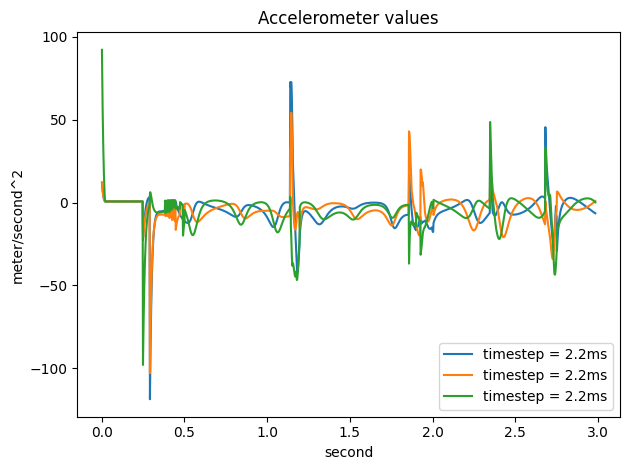

In [5]:
ax = plt.gca()
dt = 0.0022
ax.plot(np.asarray(times), np.asarray(sensordata), label='timestep = {:2.2g}ms'.format(1000*dt))

# finalize plot
ax.set_title('Accelerometer values')
ax.set_ylabel('meter/second^2')
ax.set_xlabel('second')
ax.legend(frameon=True, loc='lower right');
plt.tight_layout()

Note how the moments when the body is hit by the bat are clearly visible in the accelerometer measurements.

# Advanced rendering

Like joint visualization, additional rendering options are exposed as parameters to the `render` method.

Let's bring back our first model:

In [ ]:
xml = """
<mujoco>
  <worldbody>
    <light name="top" pos="0 0 1"/>
    <body name="box_and_sphere" euler="0 0 -30">
      <joint name="swing" type="hinge" axis="1 -1 0" pos="-.2 -.2 -.2"/>
      <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
      <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
    </body>
  </worldbody>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(xml)
renderer = mujoco.Renderer(model)
data = mujoco.MjData(model)

mujoco.mj_forward(model, data)
renderer.update_scene(data)
media.show_image(renderer.render())

In [ ]:
#@title Enable transparency and frame visualization

scene_option.frame = mujoco.mjtFrame.mjFRAME_GEOM
scene_option.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = True
renderer.update_scene(data, scene_option=scene_option)
frame = renderer.render()
media.show_image(frame)

In [ ]:
#@title Depth rendering

# update renderer to render depth
renderer.enable_depth_rendering()

# reset the scene
renderer.update_scene(data)

# depth is a float array, in meters.
depth = renderer.render()

# Shift nearest values to the origin.
depth -= depth.min()
# Scale by 2 mean distances of near rays.
depth /= 2*depth[depth <= 1].mean()
# Scale to [0, 255]
pixels = 255*np.clip(depth, 0, 1)

media.show_image(pixels.astype(np.uint8))

renderer.disable_depth_rendering()

In [ ]:
#@title Segmentation rendering

# update renderer to render segmentation
renderer.enable_segmentation_rendering()

# reset the scene
renderer.update_scene(data)

seg = renderer.render()

# Display the contents of the first channel, which contains object
# IDs. The second channel, seg[:, :, 1], contains object types.
geom_ids = seg[:, :, 0]
# Infinity is mapped to -1
geom_ids = geom_ids.astype(np.float64) + 1
# Scale to [0, 1]
geom_ids = geom_ids / geom_ids.max()
pixels = 255*geom_ids
media.show_image(pixels.astype(np.uint8))

renderer.disable_segmentation_rendering()

## The camera matrix

For a description of the camera matrix see the article [Camera matrix](https://en.wikipedia.org/wiki/Camera_matrix) on Wikipedia.

In [ ]:
def compute_camera_matrix(renderer, data):
  """Returns the 3x4 camera matrix."""
  # If the camera is a 'free' camera, we get its position and orientation
  # from the scene data structure. It is a stereo camera, so we average over
  # the left and right channels. Note: we call `self.update()` in order to
  # ensure that the contents of `scene.camera` are correct.
  renderer.update_scene(data)
  pos = np.mean([camera.pos for camera in renderer.scene.camera], axis=0)
  z = -np.mean([camera.forward for camera in renderer.scene.camera], axis=0)
  y = np.mean([camera.up for camera in renderer.scene.camera], axis=0)
  rot = np.vstack((np.cross(y, z), y, z))
  fov = model.vis.global_.fovy

  # Translation matrix (4x4).
  translation = np.eye(4)
  translation[0:3, 3] = -pos

  # Rotation matrix (4x4).
  rotation = np.eye(4)
  rotation[0:3, 0:3] = rot

  # Focal transformation matrix (3x4).
  focal_scaling = (1./np.tan(np.deg2rad(fov)/2)) * renderer.height / 2.0
  focal = np.diag([-focal_scaling, focal_scaling, 1.0, 0])[0:3, :]

  # Image matrix (3x3).
  image = np.eye(3)
  image[0, 2] = (renderer.width - 1) / 2.0
  image[1, 2] = (renderer.height - 1) / 2.0
  return image @ focal @ rotation @ translation

Let's use the camera matrix to project from world to camera coordinates:

In [ ]:
# reset the scene
renderer.update_scene(data)


# Get the world coordinates of the box corners
box_pos = data.geom_xpos[model.geom('red_box').id]
box_mat = data.geom_xmat[model.geom('red_box').id].reshape(3, 3)
box_size = model.geom_size[model.geom('red_box').id]
offsets = np.array([-1, 1]) * box_size[:, None]
xyz_local = np.stack(list(itertools.product(*offsets))).T
xyz_global = box_pos[:, None] + box_mat @ xyz_local

# Camera matrices multiply homogenous [x, y, z, 1] vectors.
corners_homogeneous = np.ones((4, xyz_global.shape[1]), dtype=float)
corners_homogeneous[:3, :] = xyz_global

# Get the camera matrix.
m = compute_camera_matrix(renderer, data)

# Project world coordinates into pixel space. See:
# https://en.wikipedia.org/wiki/3D_projection#Mathematical_formula
xs, ys, s = m @ corners_homogeneous
# x and y are in the pixel coordinate system.
x = xs / s
y = ys / s

# Render the camera view and overlay the projected corner coordinates.
pixels = renderer.render()
fig, ax = plt.subplots(1, 1)
ax.imshow(pixels)
ax.plot(x, y, '+', c='w')
ax.set_axis_off()

## Modifying the scene

Let's add some arbitrary geometry to the `mjvScene`.

In [ ]:
def get_geom_speed(model, data, geom_name):
  """Returns the speed of a geom."""
  geom_vel = np.zeros(6)
  geom_type = mujoco.mjtObj.mjOBJ_GEOM
  geom_id = data.geom(geom_name).id
  mujoco.mj_objectVelocity(model, data, geom_type, geom_id, geom_vel, 0)
  return np.linalg.norm(geom_vel)

def add_visual_capsule(scene, point1, point2, radius, rgba):
  """Adds one capsule to an mjvScene."""
  if scene.ngeom >= scene.maxgeom:
    return
  scene.ngeom += 1  # increment ngeom
  # initialise a new capsule, add it to the scene using mjv_makeConnector
  mujoco.mjv_initGeom(scene.geoms[scene.ngeom-1],
                      mujoco.mjtGeom.mjGEOM_CAPSULE, np.zeros(3),
                      np.zeros(3), np.zeros(9), rgba.astype(np.float32))
  mujoco.mjv_makeConnector(scene.geoms[scene.ngeom-1],
                           mujoco.mjtGeom.mjGEOM_CAPSULE, radius,
                           point1[0], point1[1], point1[2],
                           point2[0], point2[1], point2[2])

 # traces of time, position and speed
times = []
positions = []
speeds = []
offset = model.jnt_axis[0]/8  # offset along the joint axis

def modify_scene(scn):
  """Draw position trace, speed modifies width and colors."""
  if len(positions) > 1:
    for i in range(len(positions)-1):
      rgba=np.array((np.clip(speeds[i]/10, 0, 1),
                     np.clip(1-speeds[i]/10, 0, 1),
                     .5, 1.))
      radius=.003*(1+speeds[i])
      point1 = positions[i] + offset*times[i]
      point2 = positions[i+1] + offset*times[i+1]
      add_visual_capsule(scn, point1, point2, radius, rgba)

duration = 6    # (seconds)
framerate = 30  # (Hz)

# Simulate and display video.
frames = []

# Reset state and time.
mujoco.mj_resetData(model, data)
mujoco.mj_forward(model, data)

while data.time < duration:
  # append data to the traces
  positions.append(data.geom_xpos[data.geom("green_sphere").id].copy())
  times.append(data.time)
  speeds.append(get_geom_speed(model, data, "green_sphere"))
  mujoco.mj_step(model, data)
  if len(frames) < data.time * framerate:
    renderer.update_scene(data)
    modify_scene(renderer.scene)
    pixels = renderer.render()
    frames.append(pixels)
media.show_video(frames, fps=framerate)